In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import json
import seaborn as sns
import time
import itertools
import cProfile
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
from scipy.stats import entropy
from scipy.interpolate import interp1d

# import sys
# sys.path.append('/content/drive/MyDrive/stock_prediction')
from TimeSeriesDataset import TimeSeriesDataset

import logging
import os
import torch.nn.utils.prune as prune

## Data Preparation & Preprocessing

In [2]:
def load_configs(configs_filename):
    with open(configs_filename, 'r') as file:
        return json.load(file)

In [3]:
# Plot functions
def plot_last_prices(last_prices, normalized=True):
    plt.figure(figsize=(10, 5))
    plt.plot(last_prices, label='Normalized Prices')
    plt.legend()
    plt.ylabel('Normalized Price' if normalized else 'Price')
    plt.xlabel('Time Index')
    plt.title('Relative Change Rates of Close Prices' if normalized else 'Close Prices')
    plt.show()

def plot_volume(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data['datetime'], data['volume'])
    plt.xlabel('Date')
    plt.ylabel('Trade Volume')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_prices_with_ma(data, period, period_labels):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['last_price'], label='Last Price')
    for i in range(len(period)):
        t = period[i]
        period_label = period_labels[i]
        plt.plot(data.index, data[f'ma({t})'], label=f'{period_label} MA')
    plt.xlabel('Date')
    plt.ylabel('Last Price')
    plt.title('Prices with Moving Average')
    plt.legend()
    plt.show()

def plot_prices_with_macd(data, short_period, long_period, signal_period):
    for i in range(len(short_period)):
        plt.figure(figsize=(10, 5))
        a = short_period[i]
        b = long_period[i]
        c = signal_period[i]
        plt.plot(data.index, data[f'macd_line({a},{b},{c})'], label=f'MACD')
        plt.plot(data.index, data[f'signal_line({a},{b},{c})'], label=f'Signal')
        plt.plot(data.index, data[f'macd_histogram({a},{b},{c})'], label=f'Histogram')
        plt.xlabel('Date')
        plt.ylabel('Convergence/Divergence')
        plt.title(f"MACD({a},{b},{c})")
        plt.legend()
        plt.show()

In [4]:
# Moving Average (MA)
def moving_average(last_prices, num_periods):
    ma = last_prices.rolling(window=num_periods, min_periods=1).mean()
    # Forward fill the first num_periods-1 NaN values with the first non-NaN value
    ma.ffill(inplace=True)
    return ma

def calculate_ema(data, period):
    alpha = 2 / (period + 1)
    ema = [data.iloc[0]]  # EMA starts with the first data point

    for price in data.iloc[1:]:
        ema.append(alpha * price + (1 - alpha) * ema[-1])

    return pd.Series(ema, index=data.index)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = calculate_ema(data, short_period)
    long_ema = calculate_ema(data, long_period)

    macd_line = short_ema - long_ema
    signal_line = calculate_ema(macd_line, signal_period)
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

In [5]:
def filter_data_by_intervals(data, intervals):
    # Initialize a mask with False values
    interval_mask = pd.Series([False] * len(data))

    # Iterate over intervals and apply masks
    for start, end in intervals:
        start_time = pd.to_datetime(start).time()
        end_time = pd.to_datetime(end).time()

        # Create masks for start and end times
        start_time_mask = (data['datetime'].dt.time >= start_time)
        end_time_mask = (data['datetime'].dt.time <= end_time)

        # Combine masks based on interval crossing midnight or not
        if start_time <= end_time:
            interval_mask |= (start_time_mask & end_time_mask)
        else:
            interval_mask |= (start_time_mask | end_time_mask)

    # Apply the final mask to filter the data
    data_filtered = data[interval_mask]
    return data_filtered

def assert_time_intervals(df, intervals):
    df.index = pd.to_datetime(df.index)
    times = df.index.time

    time_intervals = [(pd.Timestamp(start).time(), pd.Timestamp(end).time()) for start, end in intervals]

    def is_within_intervals(t):
        return any(start <= t <= end if start <= end else start <= t or t <= end for start, end in time_intervals)

    outside_intervals = ~np.vectorize(is_within_intervals)(times)

    if outside_intervals.any():
        print("There are times outside the specified intervals:")
        print(df[outside_intervals])
    else:
        print("All times are within the specified intervals.")

    assert(not outside_intervals.any())

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def extract_main_contract(data_filtered, window=1000, min_periods=1, quantile=0.80):
    # Compute the rolling mean of volume
    data_filtered.loc[:, 'volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()

    # Calculate the volume threshold based on the quantile
    volume_threshold = data_filtered['volume_rolling'].quantile(quantile)

    # Identify high volume segments
    data_filtered.loc[:, 'high_volume'] = data_filtered['volume_rolling'] > volume_threshold

    # Segment identification by cumulative sum of changes in high_volume status
    data_filtered.loc[:, 'segment'] = data_filtered['high_volume'].ne(data_filtered['high_volume'].shift()).cumsum()

    # Filter the high volume segments and fill NaN values
    high_volume_segments = data_filtered[data_filtered['high_volume']]
    high_volume_segments.loc[:, 'volume'] = high_volume_segments['volume'].ffill()

    # Drop the temporary columns
    high_volume_segments.drop(columns=['high_volume', 'segment', 'volume_rolling'], inplace=True)

    return high_volume_segments


def normalize_prices(data_array, intervals, timestamps, num_steps, input_size, last_price_index=0):
    # Convert timestamps to time objects
    timestamp_times = timestamps.time

    # Create an empty array to collect normalized prices
    normalized_last_price = np.full(len(data_array), np.nan)  # Use NaN to identify unassigned values

    for start, end in intervals:
        start_time = pd.Timestamp(start).time()
        end_time = pd.Timestamp(end).time()

        # Create masks for the interval
        start_mask = timestamp_times >= start_time
        end_mask = timestamp_times <= end_time
        if start_time <= end_time:
            interval_mask = start_mask & end_mask
        else:
            interval_mask = start_mask | end_mask

        # Filter data by interval
        interval_data = data_array[interval_mask]
        clear_gpu_cache()
        if len(interval_data) == 0:
            continue

        num_windows = (len(interval_data) + input_size - 1) // input_size
        windows = np.array_split(interval_data, num_windows)

        # Create array to hold normalized values for the current interval
        interval_normalized_last_price = np.full(len(interval_data), np.nan)

        start_idx = 0
        for window_data in windows:
            if len(window_data) == 0:
                continue

            if start_idx == 0:
                window_first_price = window_data[0, last_price_index]
                values = window_data[:, last_price_index] / window_first_price - 1.0
            else:
                window_last_price = window_data[-1, last_price_index]
                values = window_data[:, last_price_index] / window_last_price - 1.0

            end_idx = start_idx + len(window_data)
            interval_normalized_last_price[start_idx:end_idx] = values
            start_idx = end_idx

        normalized_last_price[interval_mask] = interval_normalized_last_price

    # Set to the data array
    data_array[:, last_price_index] = normalized_last_price

    # Process all outliers - impute with its previous non-outlying value
    postprocess_outliers(data_array)

    # Check for NaN values
    if np.isnan(data_array[:, last_price_index]).any():
        raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")

    return data_array


def postprocess_outliers(data, threshold=0.5):
    outlier_indices = np.where(np.abs(data[:, 0]) > threshold)[0]

    for idx in outlier_indices:
        previous_value_idx = idx - 1
        while data[previous_value_idx, 0] > threshold and previous_value_idx > 0:
            previous_value_idx -= 1
        data[idx, 0] = data[previous_value_idx, 0]

def roll_data(data_array, num_steps, input_size):
    # Roll data to reshape it into the 4D shape (N, num_steps, input_size, # features)
    data_array = [np.array(data_array[i * input_size: (i + 1) * input_size])
                  for i in range(len(data_array) // input_size)]
    data_array = np.stack(data_array)
    return data_array


# Generator function
def data_generator(data_array, indices, num_steps, batch_size, last_price_index=0):
    total_len = len(indices)
    for start_idx in range(0, total_len, batch_size):
        end_idx = min(start_idx + batch_size, total_len)
        batch_indices = indices[start_idx:end_idx]
        X_batch = np.array([data_array[i: i + num_steps] for i in batch_indices])
        y_batch = data_array[batch_indices + num_steps, :, last_price_index]
        yield X_batch, y_batch


# Train-test split function
def train_test_split(data_array, num_steps, input_size, val_split, test_split, last_price_index=0):
    # Calculate the total number of samples
    total_len = len(data_array) - num_steps

    X = np.empty((total_len, num_steps, input_size, data_array.shape[-1] - 1), dtype=np.float32)
    y = np.empty((total_len, num_steps), dtype=np.float32)

    for i in range(total_len):
        X[i] = data_array[i:i + num_steps, :, 1:]  # Exclude the last_price column (column 0)
        y[i] = data_array[i:i + num_steps, :, last_price_index]  # Store the last_price values

    # Check the shapes of X and y
    num_features = data_array.shape[-1] - 1  # Exclude the last_price column
    assert X.shape == (total_len, num_steps, input_size, num_features), f"X shape mismatch: {X.shape}"
    assert y.shape == (total_len, num_steps), f"y shape mismatch: {y.shape}"
    assert len(X) == len(y), "Number of samples in X and y must be equal"

    # Determine the split indices
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))

    # Split the data
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]

    return X_train, y_train, X_val, y_val, X_test, y_test

def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    return normalized_df

# Create dataloader instances
def create_dataloader_instances(dataset, val_split, test_split, batch_size, num_workers=8):
    dataset_size = len(dataset)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * (dataset_size - test_size))
    train_size = dataset_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

# Create forward fill bid custom
def forward_fill_bid_custom(data, price_cols):
    # Forward fill NaN values across rows for specified columns
    data[price_cols] = data[price_cols].ffill(axis=1)

    # Forward fill NaN values across columns for specified columns
    data[price_cols] = data[price_cols].ffill(axis=0)

    return data

def clear_gpu_cache():
    torch.cuda.empty_cache()


# Create sequences based on the extended_segment
def create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=64):
    # Ensure no NaN values
    assert(np.isnan(extended_segment).sum().sum() == 0)

    # Setup
    timestamps = extended_segment.index
    extended_segment = extended_segment.to_numpy()
    last_price_index = 0

    # Prevent a division by 0 by imputing 0s to a very small number
    extended_segment[:, last_price_index] = np.where(extended_segment[:, last_price_index] == 0, 1e-6, extended_segment[:, last_price_index])

    # Plot the prices before normalization
    plot_last_prices(extended_segment[:, last_price_index], normalized=False)

    # Normalize prices - retrieve relative change rates
    if normalize:
        extended_segment = normalize_prices(extended_segment, intervals, timestamps, num_steps, input_size, last_price_index)

    clear_gpu_cache()

    # Plot the prices after normalization
    plot_last_prices(extended_segment[:, last_price_index])

    # Roll data for RNN
    extended_segment = roll_data(extended_segment, num_steps, input_size)
    clear_gpu_cache()

    # Create dataset and dataloader instances
    dataset = TimeSeriesDataset(extended_segment, num_steps, last_price_index)
    clear_gpu_cache()
    train_loader, val_loader, test_loader = create_dataloader_instances(dataset, val_split=val_split, test_split=test_split, batch_size=batch_size)
    clear_gpu_cache()

    # # Remove all rows with exceptionally small bid ask spread
    # extended_segment = extended_segment[:, ]

    return extended_segment, train_loader, val_loader, test_loader, dataset.num_features


def add_derived_features(extended_segment):
    # Forward fill nan values in bid_prices (NOTE: This may not reflect the changes in market!)
    bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
    ask_price_cols = ['ask_price1', 'ask_price2', 'ask_price3', 'ask_price4', 'ask_price5']
    extended_segment = forward_fill_bid_custom(extended_segment, bid_price_cols)

    # Bid & Ask Volumes
    bid_volume_cols = ['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4', 'bid_volume5']
    ask_volume_cols = ['ask_volume1', 'ask_volume2', 'ask_volume3', 'ask_volume4', 'ask_volume5']

    # Calculate Bid-Ask Spread
    extended_segment.loc[:, 'bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']

    # Calculate Market Depth (total bid and ask volumes)
    extended_segment.loc[:, 'total_bid_volume'] = extended_segment[bid_volume_cols].sum(axis=1)
    extended_segment.loc[:, 'total_ask_volume'] = extended_segment[ask_volume_cols].sum(axis=1)

    # Calculate Order Imbalance Ratio
    extended_segment.loc[:, 'order_imbalance_ratio'] = (extended_segment['total_bid_volume'] - extended_segment['total_ask_volume']) / (extended_segment['total_bid_volume'] + extended_segment['total_ask_volume'])

    # Calculate Volume Order Imbalance
    delta_bid_vol = extended_segment[bid_volume_cols].diff().fillna(0)
    delta_ask_vol = extended_segment[ask_volume_cols].diff().fillna(0)
    delta_bid_price = extended_segment[bid_price_cols].diff().fillna(0)
    delta_ask_price = extended_segment[ask_price_cols].diff().fillna(0)

    for i in range(1, 6):
        bid_vol_col = f'bid_volume{i}'
        ask_vol_col = f'ask_volume{i}'
        bid_price_col = f'bid_price{i}'
        ask_price_col = f'ask_price{i}'

        # Clip delta_bid_vol to bid_volume on a rise
        delta_bid_vol[bid_vol_col] = np.where(delta_bid_price[bid_price_col] > 0,
                                              np.minimum(delta_bid_vol[bid_vol_col], extended_segment[bid_vol_col]),
                                              delta_bid_vol[bid_vol_col])

        # Clip delta_ask_vol to ask_volume on a fall
        delta_ask_vol[ask_vol_col] = np.where(delta_ask_price[ask_price_col] < 0,
                                              np.minimum(delta_ask_vol[ask_vol_col], extended_segment[ask_vol_col]),
                                              delta_ask_vol[ask_vol_col])

    extended_segment.loc[:, 'volume_order_imbalance'] = delta_bid_vol.sum(axis=1) - delta_ask_vol.sum(axis=1)

    # Calculate Mid-Price Basis
    extended_segment.loc[:, 'mid_price'] = (extended_segment.loc[:, 'bid_price1'] + extended_segment.loc[:, 'ask_price1']) / 2

    # Calculate average trade price if it doesn't exist
    if 'average_trade_price' not in extended_segment.columns:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['mid_price']
        )
    else:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['average_trade_price'].shift(1).fillna(0)
        )

    extended_segment['mid_price_basis'] = extended_segment['average_trade_price'] - extended_segment['mid_price']

    # Drop intermediary derived feature columns
    intermediary_columns = [
        'total_bid_volume', 'total_ask_volume', 'mid_price', 'average_trade_price'
    ]
    extended_segment = extended_segment.drop(columns=intermediary_columns)

    # Ensure there are no NaN values
    assert not extended_segment.isnull().values.any(), "There are NaN values in the derived features"
    assert(np.isnan(extended_segment).sum().sum() == 0)


def add_factors(extended_segment, short_period, long_period, signal_period, period):
    # Compute Factors: MA & MACD
    for i in range(len(period)):
        # Calculate MA
        t = period[i]
        extended_segment[f'ma({t})'] = moving_average(extended_segment['last_price'], t)
        extended_segment[f'ma({t})'] = extended_segment[f'ma({t})'].fillna(method='ffill')

        # Calculate MACD
        a = short_period[i]
        b = long_period[i]
        c = signal_period[i]
        macd_line, signal_line, macd_histogram = calculate_macd(extended_segment['last_price'], a, b, c)
        extended_segment[f'macd_line({a},{b},{c})'] = macd_line
        extended_segment[f'signal_line({a},{b},{c})'] = signal_line
        extended_segment[f'macd_histogram({a},{b},{c})'] = macd_histogram

    print(extended_segment.columns)

All times are within the specified intervals.


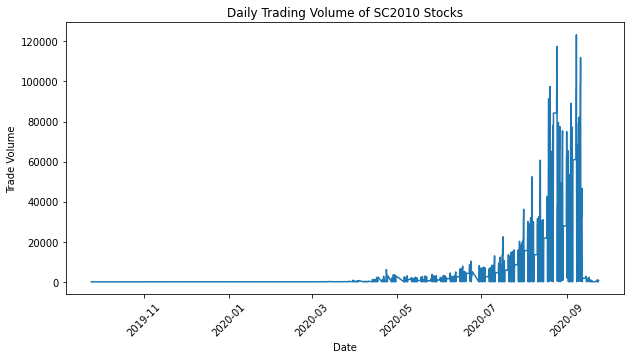

/home/ecbm4040/envTF24/lib/python3.6/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/ecbm4040/envTF24/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ecbm4040/envTF24/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

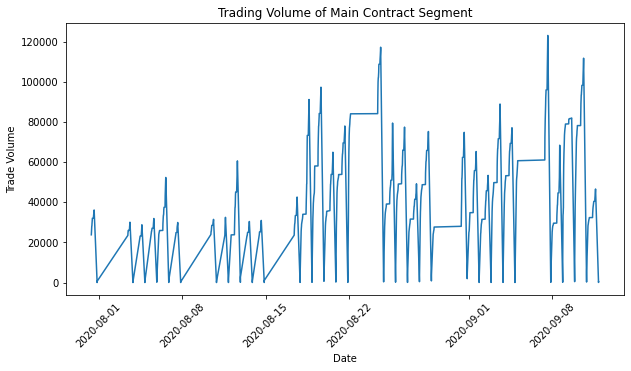

All times are within the specified intervals.


/home/ecbm4040/envTF24/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/ecbm4040/envTF24/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ecbm4040/envTF24/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Index(['last_price', 'highest', 'lowest', 'bid_price1', 'bid_volume1',
       'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4',
       'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1',
       'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4',
       'ask_volume4', 'ask_price5', 'ask_volume5', 'volume', 'amount',
       'open_interest', 'bid_ask_spread', 'total_bid_volume',
       'total_ask_volume', 'order_imbalance_ratio', 'volume_order_imbalance',
       'mid_price', 'average_trade_price', 'mid_price_basis', 'ma(5)',
       'macd_line(5,15,10)', 'signal_line(5,15,10)', 'macd_histogram(5,15,10)',
       'ma(10)', 'macd_line(10,20,20)', 'signal_line(10,20,20)',
       'macd_histogram(10,20,20)', 'ma(15)', 'macd_line(15,25,30)',
       'signal_line(15,25,30)', 'macd_histogram(15,25,30)', 'ma(20)',
       'macd_line(20,30,40)', 'signal_line(20,30,40)',
       'macd_histogram(20,30,40)'],
      dtype='object')


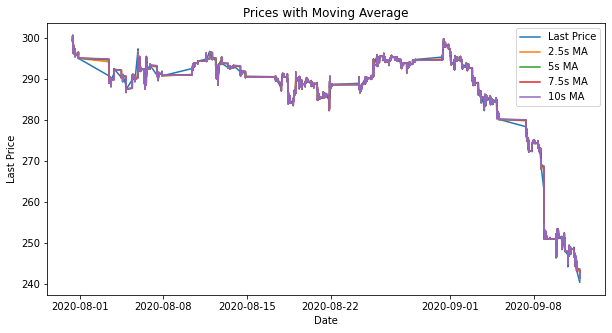

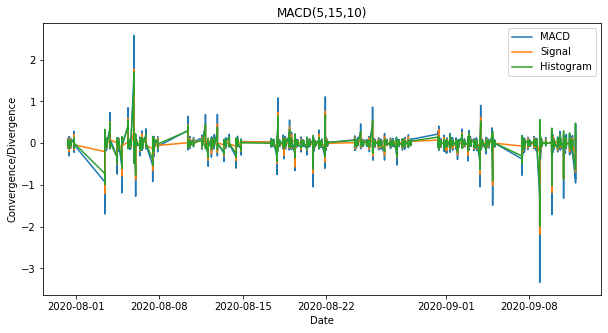

In [ ]:
# Params
intervals = [
    ('21:00:00', '02:30:00'),
    ('09:00:00', '10:15:00'),
    ('10:30:00', '11:30:00'),
    ('13:30:00', '15:00:00')
]

# Define paths
configs_filepath = 'configs/configs.json'
dataset_filepath = 'data/INE.sc2010.csv'

# Load configs file
configs = load_configs(configs_filepath)
clear_gpu_cache()

# Read data
# data = pd.read_csv('data/' + dataset_filename + '.csv')
data = pd.read_csv(dataset_filepath)
data['datetime'] = pd.to_datetime(data['datetime'])

# Set seed
set_seed(42)


# Only include data within the specified intervals
data_filtered = filter_data_by_intervals(data, intervals)
# pr.print_stats()

# Make sure there are no values outside the given time intervals
assert_time_intervals(data_filtered, intervals)
# pr.print_stats()

# Plot trading volume data
plot_volume(data_filtered, 'Daily Trading Volume of SC2010 Stocks')

# Extract the main contract
# data_filtered = data_filtered.copy() # Avoid SettingWithCopyWarning
# pr.print_stats()
data_filtered.iloc[:, 1:] = data_filtered.iloc[:, 1:].astype(np.float32)
# pr.print_stats()
extended_segment = extract_main_contract(data_filtered)
# pr.print_stats()

# Plot main contract segment
plot_volume(extended_segment, 'Trading Volume of Main Contract Segment')
# pr.print_stats()

# Set index of the resulting dataframe
extended_segment.set_index('datetime', inplace=True)
# pr.print_stats()

# Make sure there are no values outside the given time intervals
assert_time_intervals(extended_segment, intervals)
# pr.print_stats()

# Extract needed hyperparams
input_size = configs['input_size']
num_steps = configs['num_steps']
normalize = configs['normalize']
batch_size = configs['batch_size']

# Add derived features
add_derived_features(extended_segment)

# Add factors
period_labels = np.array(['2.5s', '5s', '7.5s', '10s'])
period = np.array([5, 10, 15, 20])
short_period = period
long_period = period + 10
signal_period = 2 * period

add_factors(extended_segment, short_period, long_period, signal_period, period)
# pr.print_stats()

# Plot closing prices with factors
plot_prices_with_ma(extended_segment, period, period_labels)
plot_prices_with_macd(extended_segment, short_period, long_period, signal_period)

# Normalize data
extended_segment = normalize_data(extended_segment)
assert(extended_segment.isna().sum().sum() == 0)

# Create sequences based on the extended_segment
extended_segment, train_loader, val_loader, test_loader, num_features = create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=batch_size)

## RNN Model Definition

Include quantized components when Quantized-Aware Training (QAT) enabled.

In [ ]:
def convert_to_labels(val, flat_gap=0.01):
    return 2 if val > flat_gap else 0 if val < -flat_gap else 1

In [ ]:
# def classification_accuracy(y_pred, y_true, device):
#     y_pred = y_pred.to(device)
#     y_true = y_true.to(device)
#     y_pred_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_pred)]).to(device)
#     y_true_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_true)]).to(device)
#     return torch.sum(y_pred_labels == y_true_labels) / len(y_true_labels)

def classification_accuracy(y_pred, y_true, device):
    # Ensure y_pred and y_true are on the same device
    y_pred = y_pred.to(device)
    y_true = y_true.to(device)
    
    # Apply the convert_to_labels function using PyTorch operations
    flat_y_pred = torch.flatten(y_pred)
    flat_y_true = torch.flatten(y_true)

    # Convert predictions and true values to labels using vectorized operations
    y_pred_labels = torch.where(flat_y_pred > 0.01, 2, torch.where(flat_y_pred < -0.01, 0, 1))
    y_true_labels = torch.where(flat_y_true > 0.01, 2, torch.where(flat_y_true < -0.01, 0, 1))

    # Calculate accuracy
    correct = torch.sum(y_pred_labels == y_true_labels)
    accuracy = correct.float() / len(y_true_labels)

    return accuracy

In [ ]:
# Utility function to fake quantize input to specified bit-width with stochastic rounding
def fake_quantize(x, scale, zero_point, num_bits=8, stochastic=False):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    x = x.to(torch.float32)
    qx = x / scale + zero_point

    if stochastic:
        qx = torch.floor(qx + torch.rand_like(qx))
    else:
        qx = torch.round(qx)

    qx = qx.clamp(qmin, qmax)
    return qx * scale - zero_point

def analyze_output_distribution(outputs, title="Output Distribution"):
    outputs = outputs.detach().cpu().numpy()
    if np.isnan(outputs).any():
        print(f"Warning: NaN values detected in {title}")
        return
    plt.hist(outputs.flatten(), bins=100)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Per-channel quantization function
def fake_quantize_per_channel(tensor, scales, zero_points, axis=0, num_bits=8, stochastic=False):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    scales = scales.unsqueeze(axis).expand_as(tensor)
    zero_points = zero_points.unsqueeze(axis).expand_as(tensor)
    quantized_tensor = tensor / scales + zero_points

    if stochastic:
        quantized_tensor = torch.floor(quantized_tensor + torch.rand_like(quantized_tensor))
    else:
        quantized_tensor = torch.round(quantized_tensor)

    quantized_tensor = quantized_tensor.clamp(qmin, qmax)
    return quantized_tensor * scales - zero_points

# Dynamic adjustment of scale and zero-point per channel based on output distribution
def update_scale_and_zero_point_per_channel(tensor, axis=0, num_bits=8):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    tensor_min = tensor.min(dim=axis, keepdim=True).values
    tensor_max = tensor.max(dim=axis, keepdim=True).values

    scale = (tensor_max - tensor_min) / (qmax - qmin)
    scale = torch.where(scale == 0, torch.ones_like(scale), scale)
    zero_point = torch.round(qmin - tensor_min / scale).int().clamp(qmin, qmax)

    return scale.squeeze(dim=axis), zero_point.squeeze(dim=axis)

# Update scale and zero-point with proper bit-width support
def update_scale_and_zero_point(x, num_bits=8):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1

    min_val, max_val = x.min().item(), x.max().item()

    if min_val == max_val:
        scale = 1.0
        zero_point = 0
    else:
        scale = (max_val - min_val) / (qmax - qmin)
        zero_point = qmin - min_val / scale
        zero_point = torch.round(torch.tensor(zero_point)).int().clamp(qmin, qmax)

    return scale, zero_point

# Function to dynamically update scale and zero-point per channel
def update_scale_and_zero_point_per_channel(tensor, axis=0, num_bits=8):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    tensor_min = tensor.min(dim=axis, keepdim=True).values
    tensor_max = tensor.max(dim=axis, keepdim=True).values

    scale = (tensor_max - tensor_min) / (qmax - qmin)
    scale = torch.where(scale == 0, torch.ones_like(scale), scale)
    zero_point = torch.round(qmin - tensor_min / scale).int().clamp(qmin, qmax)

    return scale.squeeze(dim=axis), zero_point.squeeze(dim=axis)

# Quantize tensor with specified bit-width and stochastic rounding
def quantize_tensor(tensor, scale, zero_point, num_bits=8, stochastic=False):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    q_tensor = tensor / scale + zero_point

    if stochastic:
        q_tensor = torch.floor(q_tensor + torch.rand_like(q_tensor))
    else:
        q_tensor = torch.round(q_tensor)

    q_tensor_new = torch.clamp(q_tensor, qmin, qmax)
    return q_tensor_new

# Quantize tensor per channel with specified bit-width and stochastic rounding
def quantize_per_channel(tensor, axis=0, num_bits=8, stochastic=False):
    scales, zero_points = update_scale_and_zero_point_per_channel(tensor, axis=axis, num_bits=num_bits)
    quantized_tensor = fake_quantize_per_channel(tensor, scales, zero_points, axis=axis, num_bits=num_bits, stochastic=stochastic)
    return quantized_tensor, scales, zero_points

# Quantize-and-dequantize operation for analysis and calibration
def quantize_and_dequantize(x, scale, zero_point, num_bits=8, stochastic=False):
    q_tensor = fake_quantize(x, scale, zero_point, num_bits=num_bits, stochastic=stochastic)
    deq_tensor = dequantize_tensor(q_tensor, scale, zero_point)
    return deq_tensor

# Per-layer quantization analysis with dynamic scale adjustment
def per_layer_analysis(layers, inputs):
    for i, layer in enumerate(layers):
        with torch.no_grad():
            outputs = layer(inputs)
            analyze_output_distribution(outputs, f"Layer {i+1} Output Distribution")

            # Update scales and zero-points dynamically during analysis
            scale, zero_point = update_scale_and_zero_point(outputs, num_bits=8)
            outputs = quantize_and_dequantize(outputs, scale, zero_point)

            inputs = outputs

# Dequantize tensor back to float
def dequantize_tensor(q_tensor, scale, zero_point):
    if not isinstance(scale, torch.Tensor):
        scale = torch.tensor(scale, dtype=torch.float32, device=q_tensor.device)
    if not isinstance(zero_point, torch.Tensor):
        zero_point = torch.tensor(zero_point, dtype=torch.float32, device=q_tensor.device)
    return (q_tensor.to(torch.float32) - zero_point) * scale

# Export model parameters with bit-width support
def export_model_parameters(model, filepath):
    model_params = {}

    for name, param in model.named_parameters():
        if param.dim() > 0:  # Ensure we're not trying to quantize a 0-dim tensor
            q_tensor, scales, zero_points = quantize_per_channel(param, num_bits=model.num_bits)
            model_params[name] = {
                "weights": q_tensor.tolist(),
                "scales": scales.tolist(),
                "zero_points": zero_points.tolist()
            }
        else:
            # For 0-dim tensors, handle separately
            model_params[name] = {
                "weights": [param.item()],
                "scales": [1.0],
                "zero_points": [0]
            }

    with open(filepath, 'w') as f:
        json.dump(model_params, f, indent=4)

# Log tensor information for debugging
def log_tensor_info(tensor, name):
    print(f"{name} shape: {tensor.shape}")
    print(f"{name} min: {tensor.min()}, max: {tensor.max()}")
    print(f"{name} mean: {tensor.to(torch.float32).mean()}")
    assert not torch.isnan(tensor).any(), f"{name} contains NaN values!"

In [ ]:
# Custom LayerNorm for internal normalization in the LSTMCell
class CustomLayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(CustomLayerNorm, self).__init__()
        self.normalized_shape = normalized_shape
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return (x - mean) / torch.sqrt(var + self.eps)

In [ ]:
class FakeQuantizationFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, zero_point, num_bits):
        # Forward pass remains the same
        ctx.save_for_backward(x, scale, zero_point)
        ctx.num_bits = num_bits
        qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
        x_q = torch.round(x / scale + zero_point)
        x_q_ = torch.clamp(x_q, qmin, qmax)
        x_q_new = (x_q_ - zero_point) * scale
        return x_q_new

    @staticmethod
    def backward(ctx, grad_output):
        x, scale, zero_point = ctx.saved_tensors
        num_bits = ctx.num_bits
        qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
        x_q = torch.round(x / scale + zero_point)
        x_q_clamped = torch.clamp(x_q, qmin, qmax)
        grad_input = grad_output / scale
        grad_scale = grad_output * (x_q_clamped - zero_point).sum() / scale
        grad_zero_point = -grad_output * (x_q_clamped - zero_point).sum()
        return grad_input, grad_scale, grad_zero_point, None

In [ ]:
# Custom LSTM Cell with quantization
class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.quantize = quantize
        self.num_bits = num_bits
        self.stochastic = stochastic

        self.W_i = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_f = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))

        self.W_c = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))

        self.W_o = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        self.batch_norm = CustomLayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

    def quantize_and_dequantize(self, x, scale, zero_point):
        return quantize_and_dequantize(x, scale, zero_point, self.num_bits, stochastic=self.stochastic)

    def quantize_weights(self, W):
        scale, zero_point = update_scale_and_zero_point_per_channel(W, axis=0, num_bits=self.num_bits)
        W_q = fake_quantize_per_channel(W, scale, zero_point, axis=0, num_bits=self.num_bits, stochastic=self.stochastic)
        return W_q, scale, zero_point

    def forward(self, x, h, c):
        if self.quantize:
            # Quantize input x
            scale_x, zero_point_x = update_scale_and_zero_point(x, self.num_bits)
            x_q = self.quantize_and_dequantize(x, scale_x, zero_point_x)

            # Quantize weights
            W_i_q, scale_w_i, zero_point_w_i = self.quantize_weights(self.W_i)
            U_i_q, scale_u_i, zero_point_u_i = self.quantize_weights(self.U_i)
            b_i_q = fake_quantize(self.b_i, scale_w_i.mean(), zero_point_w_i.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_f_q, scale_w_f, zero_point_w_f = self.quantize_weights(self.W_f)
            U_f_q, scale_u_f, zero_point_u_f = self.quantize_weights(self.U_f)
            b_f_q = fake_quantize(self.b_f, scale_w_f.mean(), zero_point_w_f.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_o_q, scale_w_o, zero_point_w_o = self.quantize_weights(self.W_o)
            U_o_q, scale_u_o, zero_point_u_o = self.quantize_weights(self.U_o)
            b_o_q = fake_quantize(self.b_o, scale_w_o.mean(), zero_point_w_o.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_c_q, scale_w_c, zero_point_w_c = self.quantize_weights(self.W_c)
            U_c_q, scale_u_c, zero_point_u_c = self.quantize_weights(self.U_c)
            b_c_q = fake_quantize(self.b_c, scale_w_c.mean(), zero_point_w_c.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            # Compute gates
            i_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_i_q.float().t()) + torch.mm(h, U_i_q.float().t()) + b_i_q))
            f_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_f_q.float().t()) + torch.mm(h, U_f_q.float().t()) + b_f_q))
            o_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_o_q.float().t()) + torch.mm(h, U_o_q.float().t()) + b_o_q))
            c_hat_t = torch.tanh(self.dropout(torch.mm(x_q, W_c_q.float().t()) + torch.mm(h, U_c_q.float().t()) + b_c_q))

        else:
            # Without quantization
            i_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_i.t()) + torch.mm(h, self.U_i.t()) + self.b_i))
            f_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_f.t()) + torch.mm(h, self.U_f.t()) + self.b_f))
            o_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_o.t()) + torch.mm(h, self.U_o.t()) + self.b_o))
            c_hat_t = torch.tanh(self.dropout(torch.mm(x, self.W_c.t()) + torch.mm(h, self.U_c.t()) + self.b_c))

        # Compute the new cell state
        c_t = f_t * c + i_t * c_hat_t

        # Apply LayerNorm to c_t
        c_t = self.batch_norm(c_t)

        # Compute the new hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize
        self.num_bits = num_bits

        self.layers = nn.ModuleList([
            CustomLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize, num_bits, stochastic=stochastic)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]

        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h, c = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                x_t, new_c = layer(x_t, h, c)

                # # Apply per-layer analysis after each layer's output
                # analyze_output_distribution(x_t, f"Layer {i+1} at time step {t+1} Output Distribution")

                hidden_states[i] = (x_t, new_c)

            outputs.append(x_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        h = torch.zeros(batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c = torch.zeros(batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return h, c

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits
        for layer in self.layers:
            layer.num_bits = num_bits

    def set_quantization(self, quantize):
        self.quantize = quantize
        for layer in self.layers:
            layer.quantize = quantize

In [ ]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.1, quantize=False, num_bits=8, stochastic=False):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.quantize = quantize
        self.num_bits = num_bits
        self.stochastic = stochastic

        self.W_z = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_z = nn.Parameter(torch.zeros(hidden_dim))

        self.W_r = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))

        self.W_h = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))

        self.batch_norm = CustomLayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

    def quantize_and_dequantize(self, x, scale, zero_point):
        return quantize_and_dequantize(x, scale, zero_point, self.num_bits, stochastic=self.stochastic)

    def quantize_weights(self, W):
        scale, zero_point = update_scale_and_zero_point_per_channel(W, axis=0, num_bits=self.num_bits)
        W_q = fake_quantize_per_channel(W, scale, zero_point, axis=0, num_bits=self.num_bits, stochastic=self.stochastic)
        return W_q, scale, zero_point

    def forward(self, x, h):
        # Ensure everything is on the correct device (same as input `x`)
        device = x.device
        h = h.to(device)
        self.W_z = self.W_z.to(device)
        self.U_z = self.U_z.to(device)
        self.b_z = self.b_z.to(device)

        self.W_r = self.W_r.to(device)
        self.U_r = self.U_r.to(device)
        self.b_r = self.b_r.to(device)

        self.W_h = self.W_h.to(device)
        self.U_h = self.U_h.to(device)
        self.b_h = self.b_h.to(device)

        if self.quantize:
            # Quantize input x and move everything to `x.device`
            scale_x, zero_point_x = update_scale_and_zero_point(x, self.num_bits)
#             scale_x, zero_point_x = scale_x.to(device), zero_point_x.to(device)
            x_q = self.quantize_and_dequantize(x, scale_x, zero_point_x)

            # Quantize weights and biases
            W_z_q, scale_w_z, zero_point_w_z = self.quantize_weights(self.W_z)
            U_z_q, scale_u_z, zero_point_u_z = self.quantize_weights(self.U_z)
            b_z_q = fake_quantize(self.b_z, scale_w_z.mean(), zero_point_w_z.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_r_q, scale_w_r, zero_point_w_r = self.quantize_weights(self.W_r)
            U_r_q, scale_u_r, zero_point_u_r = self.quantize_weights(self.U_r)
            b_r_q = fake_quantize(self.b_r, scale_w_r.mean(), zero_point_w_r.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_h_q, scale_w_h, zero_point_w_h = self.quantize_weights(self.W_h)
            U_h_q, scale_u_h, zero_point_u_h = self.quantize_weights(self.U_h)
            b_h_q = fake_quantize(self.b_h, scale_w_h.mean(), zero_point_w_h.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            # Compute gates using quantized tensors
            z_t = torch.sigmoid(torch.mm(x_q, W_z_q.float().t()) + torch.mm(h, U_z_q.float().t()) + b_z_q)
            r_t = torch.sigmoid(torch.mm(x_q, W_r_q.float().t()) + torch.mm(h, U_r_q.float().t()) + b_r_q)
            h_tilda = torch.tanh(torch.mm(x_q, W_h_q.float().t()) + r_t * torch.mm(h, U_h_q.float().t()) + b_h_q)
        else:
            # Without quantization
            z_t = torch.sigmoid(torch.mm(x, self.W_z.t()) + torch.mm(h, self.U_z.t()) + self.b_z)
            r_t = torch.sigmoid(torch.mm(x, self.W_r.t()) + torch.mm(h, self.U_r.t()) + self.b_r)
            h_tilda = torch.tanh(torch.mm(x, self.W_h.t()) + r_t * torch.mm(h, self.U_h.t()) + self.b_h)

        # Compute the new hidden state
        h_next = (1 - z_t) * h + z_t * h_tilda

        # Apply LayerNorm to h_next
        h_next = self.batch_norm(h_next.to(device))  # Ensure batch norm is on the same device

        return h_next


class CustomGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize
        self.num_bits = num_bits

        self.layers = nn.ModuleList([
            CustomGRUCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize, num_bits, stochastic=stochastic)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]

        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                x_t = layer(x_t, h)
                hidden_states[i] = x_t
            # Append output from last layer
            outputs.append(x_t)

        # Stack outputs to get the final shape (batch_size, num_steps, hidden_dim)
        outputs = torch.stack(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_dim)

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits
        for layer in self.layers:
            layer.num_bits = num_bits

    def set_quantization(self, quantize):
        self.quantize = quantize
        for layer in self.layers:
            layer.quantize = quantize


class CustomGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize
        self.num_bits = num_bits

        self.layers = nn.ModuleList([
            CustomGRUCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize, num_bits, stochastic=stochastic)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]

        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                x_t = layer(x_t, h)
                hidden_states[i] = x_t
            # Append output from last layer
            outputs.append(x_t)

        # Stack outputs to get the final shape (batch_size, num_steps, hidden_dim)
        outputs = torch.stack(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_dim)

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits
        for layer in self.layers:
            layer.num_bits = num_bits

    def set_quantization(self, quantize):
        self.quantize = quantize
        for layer in self.layers:
            layer.quantize = quantize

In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, quantize=False, num_bits=8):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.quantize = quantize
        self.num_bits = num_bits
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.quantized = False

        self.init_weights()
        self.scale_w = None
        self.zero_point_w = None

    def init_weights(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

    def quantize_and_dequantize(self, x, scale, zero_point):
        if scale is None or zero_point is None:
            raise ValueError("Quantization parameters (scale and zero_point) must be set before quantization.")

        if not isinstance(scale, torch.Tensor):
            scale = torch.tensor(scale, dtype=torch.float, device=x.device, requires_grad=False)
        if not isinstance(zero_point, torch.Tensor):
            zero_point = torch.tensor(zero_point, dtype=torch.float, device=x.device, requires_grad=False)

        return FakeQuantizationFunction.apply(x, scale.to(x.device), zero_point.to(x.device), self.num_bits)

    def forward(self, x):
        # Reshape x to 2D: (batch_size * num_steps, input_size)
        batch_size, num_steps, _ = x.size()
        x = x.view(-1, self.in_features)

        if self.quantize:
            # Quantize weights and perform matrix multiplication
            quantized_weight = self.quantize_and_dequantize(self.weight, self.scale_w, self.zero_point_w)
            output = torch.mm(x, quantized_weight.t())
        else:
            # Use the non-quantized weights
            output = torch.mm(x, self.weight.t())

        if self.bias is not None:
            output += self.bias

        # Reshape output back to 3D: (batch_size, num_steps, out_features)
        output = output.view(batch_size, num_steps, self.out_features)

        return output

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits  # Set bit precision dynamically

    def set_quantization(self, quantize):
        self.quantize = quantize
        if self.quantize:
            # Initialize quantization parameters (for example, you may set them to specific values or compute them)
            self.scale_w = torch.tensor(1.0)  # Set a default value or compute the scale
            self.zero_point_w = torch.tensor(0)  # Set a default value or compute the zero point
        else:
            # Reset quantization parameters when not quantizing
            self.scale_w, self.zero_point_w = None, None

In [ ]:
class CustomRNNModel(nn.Module):
    def __init__(self, num_steps=20, input_size=10, hidden_units=128, num_layers=3, dropout_rate=0.1, quantize=False, rnn_type='lstm', num_bits=8, stochastic=False):
        super(CustomRNNModel, self).__init__()
        self.quantize = quantize
        self.rnn_type = rnn_type
        self.num_bits = num_bits

        # Select RNN type
        if rnn_type == 'lstm':
            self.rnn = CustomLSTM(input_size * num_features, hidden_units, num_layers, dropout_rate=dropout_rate, quantize=quantize, num_bits=num_bits, stochastic=stochastic)
        elif rnn_type == 'gru':
            self.rnn = CustomGRU(input_size * num_features, hidden_units, num_layers, dropout_rate=dropout_rate, quantize=quantize, num_bits=num_bits)

        self.fc = CustomLinear(hidden_units, input_size, quantize=quantize, num_bits=num_bits)  # CustomLinear layer with quantization

        self.init_weights()

        # Assign names to RNN layers for easy quantization handling
        for layer_idx, layer in enumerate(self.rnn.layers):
            for name, param in layer.named_parameters():
                name = name.replace('.', '_')
                self.register_buffer(f'rnn{layer_idx}_{name}', param)

        # Assign names to linear layers
        for name, param in self.fc.named_parameters():
            name = name.replace('.', '_')
            self.register_buffer(f'fc_{name}', param)

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'fc' in name:
                if len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
            elif 'b' in name:
                nn.init.constant_(param, 0.0)

    def set_quantization_bits(self, num_bits):
        self.quantization_bits = num_bits
        self.rnn.set_quantization_bits(num_bits)
        self.fc.set_quantization_bits(num_bits)

    def quantize(self, x):
        scale = 2 ** (self.quantization_bits - 1) - 1
        return torch.round(x * scale) / scale

    def forward(self, x):
        # Reshape input to batch_size, num_steps, input_size
        batch_size, num_steps, input_size, num_features = x.shape
        x = torch.reshape(x, (batch_size, num_steps, input_size * num_features))

        # Pass input through RNN
        rnn_output = self.rnn(x)

        # Apply the fully connected layer on the output of the last time step
        output = self.fc(rnn_output)

        output = torch.reshape(output, (batch_size, num_steps, input_size))

        return output

    def set_quantization(self, quantize):
        self.quantize = quantize
        self.rnn.set_quantization(quantize)
        self.fc.set_quantization(quantize)

In [ ]:
# def stepwise_quantization_schedule(epoch):
#     if epoch < 10:
#         return 16
#     elif epoch < 20:
#         return 12
#     else:
#         return 8

# def linear_decay_quantization_schedule(epoch, total_epochs):
#     return max(8, 16 - (8 * epoch / total_epochs))

# def adaptive_quantization_schedule(epoch, validation_loss, threshold=2e-5):
#     if epoch < 10:
#         return 16
#     elif validation_loss > threshold:  # Define your own threshold
#         return 12
#     else:
#         return 8

# def dynamic_quantization_schedule(epoch, total_epochs):
#     if epoch < 5:
#         return 16
#     elif epoch < 20:
#         return max(8, 16 - (8 * (epoch - 5) / (total_epochs - 5)))
#     else:
#         # Optional: adjust based on final performance if needed
#         return 8

# def exponential_quantization_schedule(epoch, total_epochs):
#     decay_rate = 0.1  # Adjust this based on how quickly you want to decay
#     min_bits = 8
#     max_bits = 16
#     return max(min_bits, max_bits * math.exp(-decay_rate * epoch))

In [ ]:
def custom_loss(y_pred, y_true, y_pred_quantized, criterion):
    # Calculate standard loss
    standard_loss = criterion(y_pred, y_true)

    # Calculate quantization loss
    quantization_loss = criterion(y_pred_quantized, y_true)

    # Calculate difference between quantized vs non-quantized predictions
    quantization_diff = criterion(y_pred_quantized, y_pred)

    # Calculate quantization percent error
    quant_percent_error = torch.mean(torch.abs((y_pred - y_pred_quantized) / (y_pred.abs() + 1e-8)))

    # Calculate total loss as a weighted sum of standard and quantization losses
    total_loss = standard_loss + quantization_loss + quantization_diff

    # Return the total loss and the updated alpha
    return total_loss, standard_loss, quantization_loss, quantization_diff, quant_percent_error

In [ ]:
def save_checkpoint(state, model, filename='checkpoint.pth.tar'):
    """Save the training model's state as a checkpoint, including pruning masks."""
    state['pruning_masks'] = {name: param.clone() for name, param in model.named_buffers() if 'mask' in name}
    print("Saving checkpoint...")
    torch.save(state, filename)

def load_checkpoint(model, optimizer, scheduler, sparsity_factor=0.0, max_sparsity_increment=0.01, total_sparsity=0.0, filename='checkpoint.pth.tar'):
    """Load a training checkpoint if it exists and reapply pruning."""
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        current_bits = checkpoint['current_bits']
        patience = checkpoint['patience']
        sparsity_factor = checkpoint.get('sparsity_factor', sparsity_factor)
        max_sparsity_increment = checkpoint.get('max_sparsity_increment', max_sparsity_increment)
        total_sparsity = checkpoint.get('total_sparsity', total_sparsity)
        nan_epochs = checkpoint.get('nan_epochs', 0)
        pruning_stopped = checkpoint.get('pruning_stopped', False)

        # Reapply pruning masks
        if 'pruning_masks' in checkpoint:
            for name, mask in checkpoint['pruning_masks'].items():
                if hasattr(model, name):
                    setattr(model, name, mask)

        print(f"Checkpoint loaded successfully from '{filename}' at epoch {start_epoch}, with {current_bits} bits and sparsity factor {sparsity_factor}")
        return start_epoch, best_val_loss, current_bits, patience, sparsity_factor, max_sparsity_increment, total_sparsity, nan_epochs, pruning_stopped
    else:
        print(f"No checkpoint found at '{filename}'. Starting from scratch.")
        return 0, float('inf'), None, 0, sparsity_factor, max_sparsity_increment, total_sparsity, 0, False

In [ ]:
def plot_output_distributions(y_pred, y_pred_quantized, title="Output Distribution Comparison"):
    plt.figure(figsize=(12, 6))
    sns.histplot(y_pred, color="blue", label="Non-Quantized", kde=True)
    sns.histplot(y_pred_quantized, color="red", label="Quantized", kde=True)
    plt.title(title)
    plt.legend()
    plt.show()

def evaluate_confusion_matrix(y_true, y_pred, y_pred_quantized):
    cm_non_quantized = confusion_matrix(y_true, y_pred.argmax(axis=1))
    cm_quantized = confusion_matrix(y_true, y_pred_quantized.argmax(axis=1))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_non_quantized, annot=True, fmt="d", cmap="Blues")
    plt.title("Non-Quantized Model")
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_quantized, annot=True, fmt="d", cmap="Reds")
    plt.title("Quantized Model")
    plt.show()

In [ ]:
def apply_gradient_based_pruning(model, sparsity=0.3):
    """
    Apply gradient-based pruning to the weights of LSTM/GRU layers.
    :param model: the CustomRNNModel object (LSTM/GRU model)
    :param sparsity: the sparsity level to apply (0.3 means 30% of the weights will be pruned)
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell):
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                weight_tensor = getattr(module, weight_name)

                if weight_tensor.requires_grad:
                    weight_tensor.retain_grad()

                if weight_tensor.grad is not None:
                    gradients = torch.abs(weight_tensor.grad)
                    threshold = torch.quantile(gradients, sparsity)
                    mask = gradients > threshold

                    # Apply mask manually to prune weights
                    pruned_weight_tensor = weight_tensor * mask.float()

                    # Assign pruned weights back to the model
                    setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

        elif isinstance(module, CustomGRUCell):
            for weight_name in ['W_r', 'W_z', 'W_h']:
                weight_tensor = getattr(module, weight_name)

                if weight_tensor.requires_grad:
                    weight_tensor.retain_grad()

                if weight_tensor.grad is not None:
                    gradients = torch.abs(weight_tensor.grad)
                    threshold = torch.quantile(gradients, sparsity)
                    mask = gradients > threshold

                    pruned_weight_tensor = weight_tensor * mask.float()
                    setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

def apply_magnitude_based_pruning(model, sparsity=0.3):
    """
    Apply magnitude-based pruning to the weights of LSTM/GRU layers.
    :param model: the CustomRNNModel object (LSTM/GRU model)
    :param sparsity: the sparsity level to apply (0.3 means 30% of the weights will be pruned)
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell):
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                weights = torch.abs(getattr(module, weight_name))
                threshold = torch.quantile(weights, sparsity)
                mask = weights > threshold

                pruned_weight_tensor = getattr(module, weight_name) * mask.float()
                setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

        elif isinstance(module, CustomGRUCell):
            for weight_name in ['W_r', 'W_z', 'W_h']:
                weights = torch.abs(getattr(module, weight_name))
                threshold = torch.quantile(weights, sparsity)
                mask = weights > threshold

                pruned_weight_tensor = getattr(module, weight_name) * mask.float()
                setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))


def apply_combined_pruning(model, grad_sparsity=0.05, mag_sparsity=0.05, sparsity_dict=None, current_sparsity_factor=1.0, target_sparsity=0.6, min_remaining_percentage=39.0):
    """
    Apply gradient-based, magnitude-based, and layer-specific pruning in combination.
    The current_sparsity_factor controls the dynamic increase in pruning as training progresses.
    Pruning stops once the model reaches close to 32% remaining weights.
    """
    grad_sparsity *= current_sparsity_factor
    mag_sparsity *= current_sparsity_factor

    # Calculate current model sparsity
    actual_sparsity, percent_remaining = calculate_sparsity(model)

    # If model has reached or exceeded the minimum remaining percentage, stop pruning
    if percent_remaining <= min_remaining_percentage:
        print(f"Reached minimum remaining percentage of {min_remaining_percentage}%. Stopping further pruning.")
        return actual_sparsity, percent_remaining  # Return without further pruning

    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            # Gradient-based pruning
            apply_gradient_based_pruning(module, grad_sparsity)

            # Magnitude-based pruning
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o'] if isinstance(module, CustomLSTMCell) else ['W_r', 'W_z', 'W_h']:
                weights = torch.abs(getattr(module, weight_name))
                threshold = torch.quantile(weights, mag_sparsity)
                mask = weights > threshold

                pruned_weight_tensor = getattr(module, weight_name) * mask.float()
                setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

    # Recalculate the actual sparsity and return the updated values
    actual_sparsity, percent_remaining = calculate_sparsity(model)
    return actual_sparsity, percent_remaining

# def apply_combined_pruning(model, grad_sparsity=0.05, mag_sparsity=0.05, sparsity_dict=None, current_sparsity_factor=1.0, target_sparsity=0.6, min_remaining_percentage=39.0):
#     """
#     Apply gradient-based, magnitude-based, and layer-specific pruning in combination.
#     The current_sparsity_factor controls the dynamic increase in pruning as training progresses.
#     Pruning stops once the model reaches close to 32% remaining weights.
#     """
#     grad_sparsity *= current_sparsity_factor
#     mag_sparsity *= current_sparsity_factor

#     # Calculate current model sparsity
#     actual_sparsity, percent_remaining = calculate_sparsity(model)

#     # If model has reached or exceeded the minimum remaining percentage, stop pruning
#     if percent_remaining <= min_remaining_percentage:
#         print(f"Reached minimum remaining percentage of {min_remaining_percentage}%. Stopping further pruning.")
#         return actual_sparsity, percent_remaining  # Return without further pruning

#     for name, module in model.named_modules():
#         if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
#             # Apply layer-specific sparsity if provided
#             layer_sparsity = sparsity_dict.get(name, target_sparsity) if sparsity_dict else target_sparsity

#             # Gradient-based pruning
#             apply_gradient_based_pruning(module, grad_sparsity * layer_sparsity)

#             # Magnitude-based pruning
#             for weight_name in ['W_i', 'W_f', 'W_c', 'W_o'] if isinstance(module, CustomLSTMCell) else ['W_r', 'W_z', 'W_h']:
#                 weights = torch.abs(getattr(module, weight_name))
#                 threshold = torch.quantile(weights, mag_sparsity * layer_sparsity)
#                 mask = weights > threshold

#                 pruned_weight_tensor = getattr(module, weight_name) * mask.float()
#                 setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

#     # Recalculate the actual sparsity and return the updated values
#     actual_sparsity, percent_remaining = calculate_sparsity(model)
#     return actual_sparsity, percent_remaining

In [ ]:
def calculate_sparsity(model):
    total_weights = 0
    non_zero_weights = 0

    for name, param in model.named_parameters():
        if 'weight' in name or 'W_' in name:
            total_weights += param.numel()
            non_zero_weights += (param != 0).sum().item()  # Check for actual zeros after pruning

    sparsity = 1 - (non_zero_weights / total_weights)
    remaining_percentage = 100 * (non_zero_weights / total_weights)

    print(f'Total Weights: {total_weights}')
    print(f'Non-zero Weights: {non_zero_weights}')
    print(f'Sparsity (pruned): {sparsity * 100:.2f}%')
    print(f'Model remaining: {remaining_percentage:.2f}%')

    return sparsity, remaining_percentage

def convert_tensor_to_sparse(tensor):
    """
    Converts a dense tensor to a sparse tensor by retaining only non-zero values.
    :param tensor: The dense tensor to be converted.
    :return: A sparse version of the tensor.
    """
    if tensor.is_cuda:
        tensor = tensor.cpu()  # Convert to CPU if it's on GPU (sparse tensors are CPU-based)

    sparse_tensor = tensor.to_sparse()
    return sparse_tensor

def convert_model_to_sparse(model):
    """
    Converts the pruned model's dense weights to sparse format to save memory and improve efficiency.
    :param model: The pruned model with dense weight matrices.
    :return: The same model with sparse weights for the pruned layers.
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell):
            # Convert pruned weights to sparse format
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                dense_weight = getattr(module, weight_name)
                if hasattr(module, f'{weight_name}_mask'):
                    sparse_weight = convert_tensor_to_sparse(dense_weight)
                    # Replace the original weight with the sparse tensor
                    setattr(module, weight_name, sparse_weight)
                    # Optionally remove the mask to avoid confusion
                    delattr(module, f'{weight_name}_mask')

            if isinstance(module, CustomGRUCell):
                for weight_name in ['W_r', 'W_z', 'W_h']:
                    dense_weight = getattr(module, weight_name)
                    if hasattr(module, f'{weight_name}_mask'):
                        sparse_weight = convert_tensor_to_sparse(dense_weight)
                        setattr(module, weight_name, sparse_weight)
                        delattr(module, f'{weight_name}_mask')

    print("Model successfully converted to sparse format.")
    return model

def make_pruning_permanent(model):
    """
    Permanently remove pruning masks and apply pruning.
    This will ensure pruned weights stay zero and cannot be updated.
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            # For LSTM/GRU layers, remove pruning permanently
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                if hasattr(module, f'{weight_name}_mask'):
                    prune.remove(module, weight_name)  # Make pruning permanent

            if isinstance(module, CustomGRUCell):
                for weight_name in ['W_r', 'W_z', 'W_h']:
                    if hasattr(module, f'{weight_name}_mask'):
                        prune.remove(module, weight_name)  # Make pruning permanent

    print("Pruning masks permanently removed, ensuring pruned weights stay zero.")

def reapply_custom_pruning(model):
    """
    Reapply custom pruning masks after every optimizer step to ensure pruned weights stay zero.
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            # Apply custom mask-based pruning
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                if hasattr(module, f'{weight_name}_mask'):
                    mask = getattr(module, f'{weight_name}_mask')
                    prune.custom_from_mask(module, weight_name, mask)

            if isinstance(module, CustomGRUCell):
                for weight_name in ['W_r', 'W_z', 'W_h']:
                    if hasattr(module, f'{weight_name}_mask'):
                        mask = getattr(module, f'{weight_name}_mask')
                        prune.custom_from_mask(module, weight_name, mask)
    print("Custom pruning masks reapplied.")

def reapply_pruning_masks(model):
    """Ensure pruning masks are reapplied during training."""
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                mask = getattr(module, f'{weight_name}_mask', None)
                if mask is not None:
                    dense_weight = getattr(module, weight_name)
                    dense_weight.data.mul_(mask)

def reset_optimizer_state_for_pruned_weights(optimizer, model):
    """
    Reset optimizer state (momentum, etc.) for pruned weights so that they are not updated.
    """
    for name, param in model.named_parameters():
        if 'weight' in name or 'W_' in name and (param == 0).sum() > 0:  # Check pruned weights
            if param in optimizer.state:
                del optimizer.state[param]  # Clear optimizer state for pruned weights
    print("Cleared optimizer state for pruned weights.")


def compare_weights_before_after_step(model, optimizer, scaler):
    for name, param in model.named_parameters():
        if 'weight' in name or 'W_' in name:
            print(f"Before Step - {name}: Non-zero: {(param != 0).sum().item()}")
            # Perform the optimizer step
            scaler.step(optimizer)
            # Check weights again
            print(f"After Step - {name}: Non-zero: {(param != 0).sum().item()}")

def debug_pruning_weights(model):
    for name, param in model.named_parameters():
        if 'W_' in name or 'weight' in name:
            print(f"{name}: Non-zero before mask reapplication: {(param != 0).sum().item()}")
            # After reapplying the mask
            mask = getattr(model, f'{name}_mask', None)
            if mask is not None:
                param.data *= mask
                print(f"{name}: Non-zero after mask reapplication: {(param != 0).sum().item()}")

In [ ]:
def train_model(model, train_loader, val_loader, config, device, model_path, rnn_type='lstm',
                print_freq=10, start_bits=8, end_bits=8, checkpoint_file='checkpoint.pth.tar',
                prune=True, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6,
                sparsity_dict=None, decay_rate=0.85, prune_interval=1, min_remaining_percentage=40, prune_start_epoch=5,
                start_sparsity_factor=0.01, max_sparsity_increment=0.02, total_sparsity=0.0):
    
    # Run model on the correct device
    model = model.to(device)
    
    # Definitions
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['init_learning_rate'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['learning_rate_decay'])
    scaler = torch.cuda.amp.GradScaler()
    alpha = torch.tensor(1.0)

    # Record whether the model was originally pruned
    prune_orig = prune

    # Load checkpoint
    start_epoch, best_val_loss, current_bits, patience, current_sparsity_factor, max_sparsity_increment, total_sparsity, nan_epochs, pruning_stopped = load_checkpoint(
        model, optimizer, scheduler, filename=checkpoint_file)

    print(f"Max Sparsity Increment: {max_sparsity_increment}")

    if current_bits is None:
        current_bits = start_bits

    while current_bits >= end_bits:
        print(f"Training with {current_bits} bits")

        model.set_quantization_bits(current_bits)

        for epoch in tqdm(range(start_epoch, config['max_epochs']), leave=True):
            model.train()
            train_loss = 0.0
            nan_detected = False

            for i, (x_batch, y_batch) in tqdm(enumerate(train_loader), leave=True):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    y_pred = model(x_batch)
                    model.set_quantization(True)
                    y_pred_quantized = model(x_batch)
                    model.set_quantization(False)

                    # Calculate losses
                    total_loss, standard_loss, quantization_loss, quantization_diff, quant_percent_error = custom_loss(
                        y_pred, y_batch, y_pred_quantized, criterion
                    )

                # Handle NaN values and halt pruning
                if torch.isnan(total_loss) or torch.isnan(quant_percent_error):
                    print("NaN detected! Halting pruning increment.")
                    nan_detected = True
                    nan_epochs += 1
                    break

                # Handle NaN in gradients and skip this iteration
                for param in model.parameters():
                    if param.grad is not None:
                        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                            print("NaN or Inf found in gradients! Skipping this step.")
                            nan_detected = True
                            nan_epochs += 1
                            continue
                        # Ensure pruned weights remain zero
                        mask = param == 0
                        param.grad[mask] = 0

                # Apply backpropagation
                scaler.scale(total_loss).backward(retain_graph=True)

                # Perform pruning if necessary
                if prune and not pruning_stopped and epoch >= prune_start_epoch and (i % prune_interval) == 0:
                    # Check the sparsity before every step
                    actual_sparsity, percent_remaining = calculate_sparsity(model)
                    print(f"Checking sparsity at Step [{i+1}/{len(train_loader)}]")
                    print(f"Current model sparsity: {actual_sparsity * 100:.2f}%, Remaining: {percent_remaining:.2f}%")

                    # If model has reached or exceeded the minimum remaining percentage, stop pruning
                    if percent_remaining <= min_remaining_percentage:
                        print(f"Reached minimum remaining percentage of {min_remaining_percentage}%. Stopping further pruning.")
                        pruning_stopped = True  # Stop any future pruning
                    else:
                        print(f"Pruning step. Current sparsity factor: {current_sparsity_factor}")
                        actual_sparsity, percent_remaining = apply_combined_pruning(
                            model, grad_sparsity=grad_sparsity, mag_sparsity=mag_sparsity,
                            sparsity_dict=sparsity_dict, current_sparsity_factor=current_sparsity_factor
                        )
                        print(f"After pruning, Actual Sparsity: {actual_sparsity * 100:.2f}%, Remaining: {percent_remaining:.2f}%")

                        # Increment the sparsity factor for the next pruning step
                        max_sparsity_increment *= decay_rate  # Decay the rate of sparsity growth
                        current_sparsity_factor += max_sparsity_increment
                        total_sparsity += current_sparsity_factor
                        print(f"Updated Current Sparsity Factor: {current_sparsity_factor}")
                        print(f"Updated Total Sparsity: {total_sparsity}")

                # Clip gradients to avoid exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

                # Step the scaler
                scaler.step(optimizer)

                # Update weights
                scaler.update()

                # Accumulate training loss
                train_loss += total_loss.item()

                if i % print_freq == 0:
                    print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Step [{i + 1}/{len(train_loader)}], Loss: {total_loss.item()}')
                    print(f'Alpha: {alpha.item()}')
                    print(f'Sparsity factor: {current_sparsity_factor}')
                    print(f'Total sparsity: {total_sparsity}')
                    print(f'NaN epochs: {nan_epochs}')

                    # Recalculate the sparsity after each iteration
                    actual_sparsity, percent_remaining = calculate_sparsity(model)
                    print(f"Actual model sparsity: {actual_sparsity * 100:.2f}%")
                    print(f"Percentage remaining: {percent_remaining:.2f}%")

                    print(f'Patience: {patience}')
                    print('Training Loss Standard:', standard_loss.item())
                    print('Training Loss Quantized:', quantization_loss.item())
                    print('Training Quantization Diff:', quantization_diff.item())
                    print(f'Training Quant Percent Diff in Outputs: {100 * quant_percent_error.item()}%')
                    print(f'Training Percent Diff in Loss: {100 * (quantization_loss - standard_loss) / (standard_loss + 1e-8).item()}%')
                    print('Training classification accuracy standard:', classification_accuracy(y_pred, y_batch, device).item())
                    print('Training classification accuracy quantized:', classification_accuracy(y_pred_quantized, y_batch, device).item())

            # Reapply pruning masks at the end of epoch
            reapply_custom_pruning(model)

            # Ensure optimizer state is reset for pruned weights
            reset_optimizer_state_for_pruned_weights(optimizer, model)

            # Reduce sparsity increment if NaNs occur
            if nan_detected:
                current_sparsity_factor = max(0.0, current_sparsity_factor - max_sparsity_increment / 2)

            # Validation and checkpoint logic
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for i, (x_batch, y_batch) in tqdm(enumerate(val_loader), position=0, leave=True):
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    with torch.cuda.amp.autocast():
                        y_pred = model(x_batch)
                        model.set_quantization(True)
                        y_pred_quantized = model(x_batch)
                        model.set_quantization(False)

                        total_loss, standard_loss, quantization_loss, quantization_diff, quant_percent_error = custom_loss(
                            y_pred, y_batch, y_pred_quantized, criterion
                        )

                    val_loss += total_loss.item()

                    if i % print_freq == 0:
                        print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Step [{i + 1}/{len(val_loader)}], Loss: {total_loss.item()}')
                        print(f'Alpha: {alpha.item()}')
                        print(f'Sparsity factor: {current_sparsity_factor}')
                        print(f'Total sparsity: {total_sparsity}')
                        print(f'NaN epochs: {nan_epochs}')
                        print(f'Patience: {patience}')
                        print('Validation Loss Standard:', standard_loss.item())
                        print('Validation Loss Quantized:', quantization_loss.item())
                        print('Validation Quantization Diff:', quantization_diff.item())
                        print(f'Validation Quant Percent Diff in Outputs: {100 * quant_percent_error.item()}%')
                        print(f'Validation Percent Diff in Loss: {100 * (quantization_loss - standard_loss) / (standard_loss + 1e-8).item()}%')
                        print('Validation classification accuracy standard:', classification_accuracy(y_pred, y_batch, device).item())
                        print('Validation classification accuracy quantized:', classification_accuracy(y_pred_quantized, y_batch, device).item())

            val_loss /= len(val_loader)
            print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Validation Loss: {val_loss}')

            # Save checkpoint if validation improves
            if prune_orig and pruning_stopped:  # ONLY start recording best validation loss after pruning has finished
                is_best = val_loss < best_val_loss
                if is_best:
                    best_val_loss = val_loss
                    patience = 0
                    print('Saving model with best validation loss...')
                    torch.save(model.state_dict(), model_path)
                else:
                    patience += 1
                    if patience >= config['early_stop_patience']:
                        print("Early stopping due to lack of improvement.")
                        break

            # If model has been pruned
            has_been_pruned = prune_orig and epoch >= prune_start_epoch
            if has_been_pruned:
                # Immediately convert pruned weights to sparse format and store in state_dict
                model = convert_model_to_sparse(model)

            # Save the current training state and pruning progress
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_val_loss': best_val_loss,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'current_bits': current_bits,
                'patience': patience,
                'sparsity_factor': current_sparsity_factor,
                'max_sparsity_increment': max_sparsity_increment,
                'total_sparsity': total_sparsity,
                'nan_epochs': nan_epochs,
                'pruning_stopped': pruning_stopped
            }, model, filename=checkpoint_file)

            scheduler.step()

        current_bits -= 1
        start_epoch = 0

    print('Training complete.')
    return model

In [ ]:
def load_model(model, model_path, device):
    # Load the original state dictionary from disk
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    return model

In [ ]:
def train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=False, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6, prune_interval=1, min_remaining_percentage=40, prune_start_epoch=2, decay_rate=0.9, start_sparsity_factor=0.1, max_sparsity_increment=0.01, total_sparsity=0.0, checkpoint_file='checkpoint.pth.tar'):
    # Define model & load into device
    model = CustomRNNModel(rnn_type=rnn_type, num_steps=configs['num_steps'], input_size=configs['input_size'], hidden_units=configs[rnn_type][f'{rnn_type}_units'], num_layers=configs[rnn_type][f'{rnn_type}_layers'], dropout_rate=configs[rnn_type]['dropout_rate'], stochastic=True)
    model = model.to(device)

    # Keep a copy of whether we originally set to prune the model
    prune_orig = prune

    # Train the model and save checkpoints
    if configs[rnn_type]['pretrain']:
        # Apply magnitude-based and layer-specific pruning before training
        if prune:
            sparsity_dict = {'rnn.layers.0': 0.2, 'rnn.layers.1': 0.3, 'rnn.layers.2': 0.3}  # Layer-specific sparsity levels

        model = train_model(model, train_loader, val_loader, configs[rnn_type], device, model_path, prune=prune, grad_sparsity=grad_sparsity, mag_sparsity=mag_sparsity, target_sparsity=target_sparsity, prune_interval=prune_interval, min_remaining_percentage=min_remaining_percentage, sparsity_dict=sparsity_dict, prune_start_epoch=prune_start_epoch, decay_rate=decay_rate, start_sparsity_factor=start_sparsity_factor, max_sparsity_increment=max_sparsity_increment, total_sparsity=total_sparsity, rnn_type=rnn_type, checkpoint_file=checkpoint_file)

    # Load the model from the latest checkpoint
    model = load_model(model, model_path, device)

    # Convert pruned model to sparse format after training, but keep sparsity.
    if prune_orig:
        convert_model_to_sparse(model)

    return model

In [ ]:
def mean_percent_diff(quant_outputs, noquant_outputs):
    total_abs_diff = 0.0
    total_elements = 0

    # Iterate through each batch in the list
    for i in range(len(noquant_outputs)):
        noquant = noquant_outputs[i]
        quant = quant_outputs[i]

        # Ensure shapes match
        if noquant.shape != quant.shape:
            raise ValueError(f"Shape mismatch: {noquant.shape} vs {quant.shape}")

        # Calculate absolute differences
        abs_diff = np.abs(noquant - quant)

        # Calculate percent differences
        percent_diff = (abs_diff / (np.abs(noquant) + 1e-8)) * 100

        # Aggregate differences
        total_abs_diff += np.sum(percent_diff)
        total_elements += np.size(percent_diff)

    # Calculate mean percent difference
    percent_diff = total_abs_diff / total_elements
    return percent_diff


# Evaluate the model
def evaluate_model(model, test_loader, device, quantize=False):
    # Set the model to evaluation mode
    model.eval()

    # Apply quantization if specified
    model.set_quantization(quantize)

    test_loss = 0.0
    test_accuracy = 0.0

    preds = []

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over test set data
        for i, (x_batch, y_batch) in tqdm(enumerate(test_loader), position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.MSELoss()(y_pred, y_batch)
            preds.append(y_pred.cpu().numpy())  # Ensure data is on CPU for numpy operations
            test_loss += loss.item()
            test_accuracy += classification_accuracy(y_pred, y_batch).item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = test_accuracy / len(test_loader)

    print("Test Loss:", test_loss)
    print('Test Classification Accuracy:', test_accuracy)

    return preds, test_loss, test_accuracy

In [ ]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Reset configs
configs = load_configs(configs_filepath)

## Training + Evaluation Results:

### LSTM (without pruning):

In [ ]:
rnn_type = 'lstm'
model_path = f'models/SC2010_{rnn_type}_model_QAT.pth'
checkpoint_path = f'checkpoints/SC2010_{rnn_type}_checkpoint_QAT.pth'
model_params_path = f'models/SC2010_quantized_{rnn_type}_parameters_QAT.json'

# Training
model_lstm = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, checkpoint_file=checkpoint_path)

# Export model parameters to JSON file
export_model_parameters(model_lstm, model_params_path)

<ipython-input-23-7daf876e726a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


#### Without Quantization:

In [ ]:
# Evaluation
test_preds_lstm_noquant, test_loss_lstm_noquant, test_accuracy_lstm_noquant = evaluate_model(model_lstm, test_loader, device, quantize=False)

0it [00:00, ?it/s]

Test Loss: 1.9616683338037027e-05
Test Classification Accuracy: 0.9756905862263271


#### With Quantization:

In [ ]:
# Evaluation
test_preds_lstm_quant, test_loss_lstm_quant, test_accuracy_lstm_quant = evaluate_model(model_lstm, test_loader, device, quantize=True)

0it [00:00, ?it/s]

Test Loss: 1.941479656254939e-05
Test Classification Accuracy: 0.9756949033055987


### LSTM (with pruning):

In [ ]:
rnn_type = 'lstm'
model_path = f'models/SC2010_{rnn_type}_model_QAT_sparsity.pth'
checkpoint_path = f'checkpoints/SC2010_{rnn_type}_checkpoint_QAT_sparsity.pth'
model_params_path = f'models/SC2010_quantized_{rnn_type}_parameters_QAT_sparsity.json'

# Training
model_lstm_sparsify = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=True, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6, prune_interval=1, min_remaining_percentage=40, prune_start_epoch=3, start_sparsity_factor=0.005, decay_rate=0.9, max_sparsity_increment=0.005, checkpoint_file=checkpoint_path)

# Export model parameters to JSON file
export_model_parameters(model_lstm_sparsify, model_params_path)

# Calculate sparsity
sparsity, remaining_percentage = calculate_sparsity(model_lstm_sparsify)
print(f'Final model sparsity: {sparsity * 100:.2f}%')
print(f'Model is {remaining_percentage:.2f}% of its original size after pruning.')

<ipython-input-23-7daf876e726a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model successfully converted to sparse format.
Total Weights: 448768
Non-zero Weights: 175458
Sparsity (pruned): 60.90%
Model remaining: 39.10%
Final model sparsity: 60.90%
Model is 39.10% of its original size after pruning.


#### Without Quantization:

In [ ]:
# Evaluation
test_preds_lstm_noquant_sparsify, test_loss_lstm_noquant_sparsify, test_accuracy_lstm_noquant_sparsify = evaluate_model(model_lstm_sparsify, test_loader, device, quantize=False)

0it [00:00, ?it/s]

Test Loss: 2.1842273002091262e-05
Test Classification Accuracy: 0.9756949033055987


#### With Quantization:

In [ ]:
# Evaluation
test_preds_lstm_quant_sparsify, test_loss_lstm_quant_sparsify, test_accuracy_lstm_quant_sparsify = evaluate_model(model_lstm_sparsify, test_loader, device, quantize=True)

0it [00:00, ?it/s]

Test Loss: 1.9432312391083023e-05
Test Classification Accuracy: 0.9756949033055987


### GRU (without pruning):

In [ ]:
rnn_type = 'gru'
model_path = f'models/SC2010_{rnn_type}_model_QAT.pth'
checkpoint_path = f'checkpoints/SC2010_{rnn_type}_checkpoint_QAT.pth'
model_params_path = f'models/SC2010_quantized_{rnn_type}_parameters_QAT.json'

# Training
model_gru = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=True, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6, prune_interval=3, min_remaining_percentage=39, prune_start_epoch=3, start_sparsity_factor=0.0, decay_rate=1.0, max_sparsity_increment=0.01, checkpoint_file=checkpoint_path)

# Export model parameters to JSON file
export_model_parameters(model_gru, model_params_path)

<ipython-input-39-7daf876e726a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model successfully converted to sparse format.


#### Without Quantization:

In [ ]:
# Evaluation
test_preds_gru_noquant, test_loss_gru_noquant, test_accuracy_gru_noquant = evaluate_model(model_gru, test_loader, device, quantize=False)

0it [00:00, ?it/s]

Test Loss: 2.1501414396750208e-05
Test Classification Accuracy: 0.9751470514706203


#### With Quantization:

In [ ]:
# Evaluation
test_preds_gru_quant, test_loss_gru_quant, test_accuracy_gru_quant = evaluate_model(model_gru, test_loader, device, quantize=True)

0it [00:00, ?it/s]

Test Loss: 1.9415038747995694e-05
Test Classification Accuracy: 0.9756949033055987


### GRU (with pruning):

In [ ]:
rnn_type = 'gru'
model_path = f'models/SC2010_{rnn_type}_model_QAT_sparsity.pth'
checkpoint_path = f'checkpoints/SC2010_{rnn_type}_checkpoint_QAT_sparsity.pth'
model_params_path = f'models/SC2010_quantized_{rnn_type}_parameters_QAT_sparsity.json'

# Training
configs[rnn_type]['pretrain'] = True
model_gru_sparsify = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=True, grad_sparsity=0.03, mag_sparsity=0.03, target_sparsity=0.6, prune_interval=1, min_remaining_percentage=40, prune_start_epoch=9, start_sparsity_factor=0.005, decay_rate=0.9, max_sparsity_increment=0.005, checkpoint_file=checkpoint_path)
configs[rnn_type]['pretrain'] = False

# Export model parameters to JSON file
export_model_parameters(model_gru_sparsify, model_params_path)

# Calculate sparsity
sparsity, remaining_percentage = calculate_sparsity(model_gru_sparsify)
print(f'Final model sparsity: {sparsity * 100:.2f}%')
print(f'Model is {remaining_percentage:.2f}% of its original size after pruning.')

#### Without Quantization:

In [ ]:
# Evaluation
test_preds_gru_noquant_sparsify, test_loss_gru_noquant_sparsify, test_accuracy_gru_noquant_sparsify = evaluate_model(model_gru_sparsify, test_loader, device, quantize=False)

#### With Quantization:

In [ ]:
# Evaluation
test_preds_gru_quant_sparsify, test_loss_gru_quant_sparsify, test_accuracy_gru_quant_sparsify = evaluate_model(model_gru_sparsify, test_loader, device, quantize=True)